In [19]:
import loadLE as le
import cccmautils as cutl

%matplotlib inline


field = 'sic'; ncfield='sic'; comp='OImon'; conv=1; region='bksmori'
fieldtas = 'tas'; ncfieldtas='tas'; comptas='Amon'; convtas=1; regiontas='eurasiamori'
timeselc = '1979-01-01,1989-12-31'
timeselp = '2002-01-01,2012-12-31'
timesel = '1979-01-01,2012-12-31' # for trend

sea='DJF'

local = True

In [2]:
def load_field(fdict,casename,timesel,seas=None,mo=0,ftype='fullts',orig=None,calc=None,conv=1,local=False,verb=False):
    
    """ TAKEN FROM load_field() in canesm_le_composite.py/pi_pdf_uncertainty.py

        returns [numens x space.flat] or [numens]

    """

    ledat = le.load_LEdata(fdict,casename,timesel=timesel, 
                           rettype='ndarray',conv=conv,ftype=ftype,orig=orig,local=local,verb=verb)

    # time needs to be first dimension
    try:
        if ledat.ndim==2:
            ledat = ledat.T
        elif ledat.ndim==3:
            ledat = np.transpose(ledat,(1,0,2))
        else:
            print 'Loaded data is not 2 or 3 dimensions. Do not understand.'
            raise Exception
    except:
        raise

    if seas==None and mo==0:
        lesea=ledat        
    else:
    
        lesea = cutl.seasonalize(ledat,season=seas,mo=mo) # time x numens x space.flat

    if calc!=None and calc=='trend':
        
        mm,bb=cutl.trend_monthly(lesea) # should return 12 x numens x space.flat
        return lesea,mm,bb
    else:
    
        return lesea




In [9]:
fdict = {'field': field+region, 'ncfield': ncfield, 'comp': comp}

# load SIA
lerawc = load_field(fdict, 'historical', timeselc,seas=sea, verb=False,
                    ftype='fullts', orig=None,conv=conv,local=local)
lerawp = load_field(fdict, 'historical', timeselp,seas=sea, verb=False,
                    ftype='fullts', orig=None,conv=conv,local=local)


fdicttas = {'field': fieldtas+regiontas, 'ncfield': ncfieldtas, 'comp': comptas}

# load SAT
lerawtasc = load_field(fdicttas, 'historical', timeselc,seas=sea, verb=False,
                    ftype='fullts', orig=None,conv=conv,local=local)
lerawtasp = load_field(fdicttas, 'historical', timeselp,seas=sea, verb=False,
                    ftype='fullts', orig=None,conv=conv,local=local)


(50, 132)
(50, 132)
(50, 132)
(50, 132)
(50, 132)
(50, 132)
(50, 132)
(50, 132)


In [15]:
lesic = lerawp.mean(axis=0) - lerawc.mean(axis=0)
letas = lerawtasp.mean(axis=0) - lerawtasc.mean(axis=0)

letasstd = (lerawtasp - lerawtasc).std(axis=0)

lemat = np.array((lesic,letas))

(50,)
regress pval,rval: 0.0725112579475 -0.256200250506


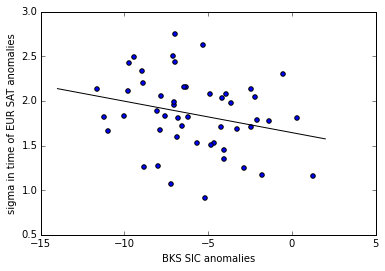

In [58]:
cutl=reload(cutl)
cplt=reload(cplt)

lemat.shape

yy,bined = np.histogram(lemat[0,...])

print letasstd.shape

plt.figure()
plt.scatter(lesic,letasstd)
plt.ylabel('sigma in time of EUR SAT anomalies')
plt.xlabel('BKS SIC anomalies')
cplt.add_regressline(lesic,letasstd)

In [26]:
indices = [0,1,11]
wgts = np.array([31, 31, 28])/np.float(np.array([31, 31, 28]).sum())

fdict = {'field': field+region, 'ncfield': ncfield, 'comp': comp}

# load SIA
lerawtr,mm,bb = load_field(fdict, 'historical', timesel,calc='trend',verb=False,
                    ftype='fullts', orig=None,conv=conv,local=local)


fdicttas = {'field': fieldtas+regiontas, 'ncfield': ncfieldtas, 'comp': comptas}

# load SAT
lerawtastr,mmtas,bbtas = load_field(fdicttas, 'historical', timesel,calc='trend',verb=False,
                    ftype='fullts', orig=None,conv=conv,local=local)


mmsea = np.average(mm[indices,:], axis=0,weights=wgts)
mmtassea = np.average(mmtas[indices,:], axis=0,weights=wgts)

lerawsea = cutl.seasonalize(lerawtr,season='DJF')
lerawtassea = cutl.seasonalize(lerawtastr,season='DJF')


(50, 408)
(50, 408)
(50, 408)
(50, 408)


regress pval,rval: 0.698652809774 -0.0561262169812
regress pval,rval: 0.114851333216 -0.225807670374


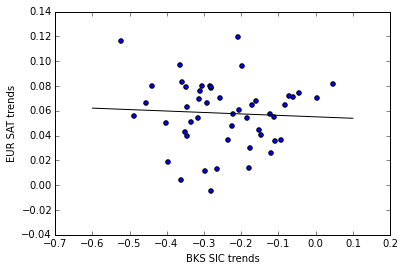

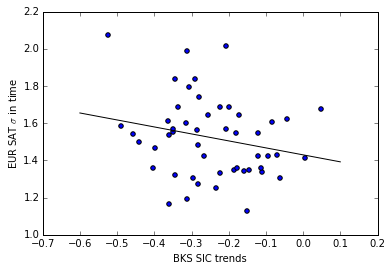

In [60]:
import numpy.ma as ma

plt.figure()
plt.scatter(mmsea,mmtassea)
plt.ylabel('EUR SAT trends')
plt.xlabel('BKS SIC trends')
cplt.add_regressline(mmsea,mmtassea)

yy,bined = np.histogram(mmsea)

mmseam = mmsea
spreads=np.zeros(len(bined)-1)
tasspreads=np.zeros(len(bined)-1)
for bii in np.arange(0,len(bined)-1):
    
    # get index of SIC w/in bin:
    # calc spread within a bin by masking out everything else
    mmseam = ma.masked_outside(mmsea,bined[bii], bined[bii+1])
    mmtasseam = ma.masked_where(mmseam.mask,mmtassea)
    spreads[bii] = mmseam.std()
    tasspreads[bii] = mmtasseam.std()
    
    
    
lerawsea = cutl.seasonalize(lerawtr,season='DJF')
lerawtassea = cutl.seasonalize(lerawtastr,season='DJF')

# compute sigma of SAT in time for each SIC trend
lesig = lerawsea.std(axis=0)
letassig = lerawtassea.std(axis=0)

plt.figure()
plt.scatter(mmsea,letassig)
plt.ylabel('EUR SAT $\sigma$ in time')
plt.xlabel('BKS SIC trends')
cplt.add_regressline(mmsea,letassig)

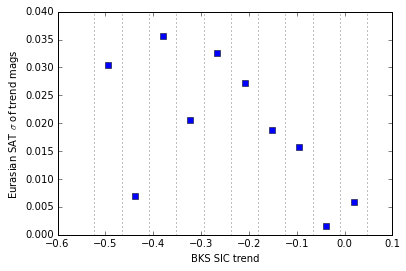

In [49]:
plt.figure()
plt.plot((bined[0:-1]+bined[1:])/2,tasspreads, linestyle='none',marker='s')
plt.ylabel('Eurasian SAT $\sigma$ of trend mags')
plt.xlabel('BKS SIC trend')
for be in bined:
    plt.axvline(be,color='0.5',linestyle=':')

In [52]:
lerawtr.shape

(408, 50)